# Auto Crop signal

Usually, when recording either radio waves or sound waves, you start recording, the signal comes, and then, as the slow human being that you are (slow relative to computers), you stop recording a while after the signal transmission completed.

But usually, you just want the signal and don't care about the surrounding dead air/noise.

To this end, let's develop an algorithm to auto-crop the signal of interest. We will do this by:
* breaking the signal into 16 chunks
* calculating the power in each chunk
* finding where the largest increase in power happens
* finding where the largest decrease in power happens
* saving only the portion between the largest power increase in decrease

Since this is mostly meant for use with radio signals, we will experiment with a radio signal in the [PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation) [raw wave format](https://en.wikipedia.org/wiki/Raw_audio_format) - which is essentially the same as a [WAV](https://en.wikipedia.org/wiki/WAV) file without the headers.

# Graphing boilerplate code

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
#import scipy.io.wavfile

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Auto crop algorithm

In [3]:
def auto_crop_signal(signal_data, margin_percent=1, num_chunks=16):
    """ Break the signal into chunks, and find the chunk there is the largest
    jump from quiet to loud (start index), and the largest jump from 
    loud to quiet (stop index). """
    chunk_size = int(len(signal_data) / num_chunks)
    largest_increase_index = 0
    largest_increase_size = -999999999
    largest_decrease_index = chunk_size * num_chunks
    largest_decrease_size = 999999999
    last_chunk_sum = sum([abs(i) for i in signal_data[0:chunk_size]])
    for chunk_start in range(0, len(signal_data), chunk_size):
        chunk = signal_data[chunk_start:chunk_start+chunk_size]
        # Don't consider the last chunk if it's not a full chunk,
        # since that will likely yield the smallest sum
        if len(chunk) < chunk_size:
            continue
        chunk_sum = sum([abs(i) for i in chunk])
        chunk_diff = chunk_sum - last_chunk_sum
        last_chunk_sum = chunk_sum
        if chunk_diff > largest_increase_size:
            largest_increase_size = chunk_diff
            largest_increase_index = chunk_start
        if chunk_diff < largest_decrease_size:
            largest_decrease_size = chunk_diff
            largest_decrease_index = chunk_start
    margin = int((largest_decrease_index - largest_increase_index) * (margin_percent / 100))
    return signal_data[largest_increase_index-margin:largest_decrease_index+margin]


# Read in PCM file

In [4]:
in_signal = scipy.fromfile(open('raw_signal_to_crop.pcm'), dtype=scipy.complex64)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


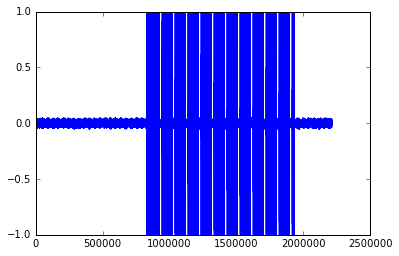

In [5]:
plt.plot(in_signal)

In [6]:
cropped_sig = auto_crop_signal(in_signal)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


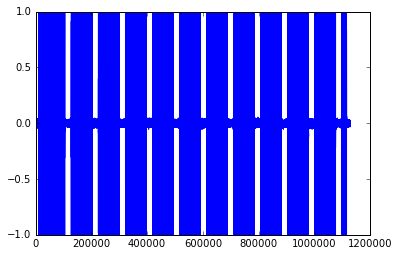

In [7]:
plt.plot(cropped_sig)

# Write file

In [8]:
def write_pcm_file(signal_data, file_path):
    np.array(signal_data).astype('complex64').tofile(file_path)


In [9]:
write_pcm_file(cropped_sig, 'cropped_sig.pcm')

# Verify write worked by reading back in

In [10]:
read_cropped = scipy.fromfile(open('cropped_sig.pcm'), dtype=scipy.complex64)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


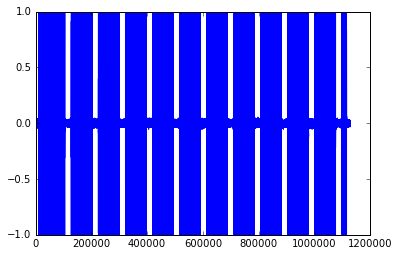

In [11]:
plt.plot(read_cropped)

In [14]:
read_cropped[2]

(0.0078125+0.0234375j)